# Shopee Product Classification 

Notebook to experiment over several Neural Networks over the product dataset obtained from Shopee and evaluate results.

The following models are evaluated as part of this notebook:

Baseline 1: CNN <br>
Baseline 2: CNN with augmented layers <br>
Improvement 1: Adding ANN <br>
Improvement 2: Adding RNN <br>

## Imports and Config

In [1]:
!pip install scikit-image
!pip install shopee_crawler
!pip install torchvision
!pip install opencv-python

  Using cached scikit_image-0.19.3-cp39-cp39-macosx_12_0_arm64.whl (12.5 MB)
  Using cached PyWavelets-1.4.1-cp39-cp39-macosx_11_0_arm64.whl (4.3 MB)
  Using cached tifffile-2022.10.10-py3-none-any.whl (210 kB)
  Using cached imageio-2.22.2-py3-none-any.whl (3.4 MB)
  Using cached networkx-2.8.7-py3-none-any.whl (2.0 MB)
  Using cached scipy-1.9.3-cp39-cp39-macosx_12_0_arm64.whl (28.6 MB)
  Using cached opencv_python-4.6.0.66-cp37-abi3-macosx_11_0_arm64.whl (30.0 MB)


In [10]:
import os
import sys
import json
import importlib
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from utils import file_utils, dataset
from scripts import crawler

import ipywidgets as widgets

import cv2
import torch
import torch.nn as nn
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from torchvision import transforms, models, datasets


In [67]:
crawler

<module 'scripts.crawler' from 'C:\\Users\\admin\\Documents\\GitHub\\cs5242-project\\scripts\\crawler.py'>

In [135]:
# Can use this to reload file when editing for faster changes
importlib.reload(dataset)

<module 'utils.dataset' from 'C:\\Users\\admin\\Documents\\GitHub\\cs5242-project\\utils\\dataset.py'>

## Data Load

In [3]:
image_dir = 'data/images'

In [115]:
if(file_utils.check_images_dir()):
    print(f'Images already exist at: {file_utils.images}')
elif(file_utils.check_tar_exists()):
    print(f'Images not yet extracted')
    print(f'Image zip exists at: {file_utils.images_zip}')
    file_utils.extract_tar()
else:
    print(f'Images need to be downloaded')
    for c in category_urls:
        get_category_data('data', c)
    download_images('data')

Images already exist at: data/images


## Note: To be in accordance with other folders, changes to make:
- Add "-cat" to Women's Apparel directory after unzipping (Maybe we handle when we're zipping itself? Otherwise we can add a condition for this in the dataloader too)

## Dataset

In [7]:
data = dataset.DataSet()

<BarContainer object of 25 artists>

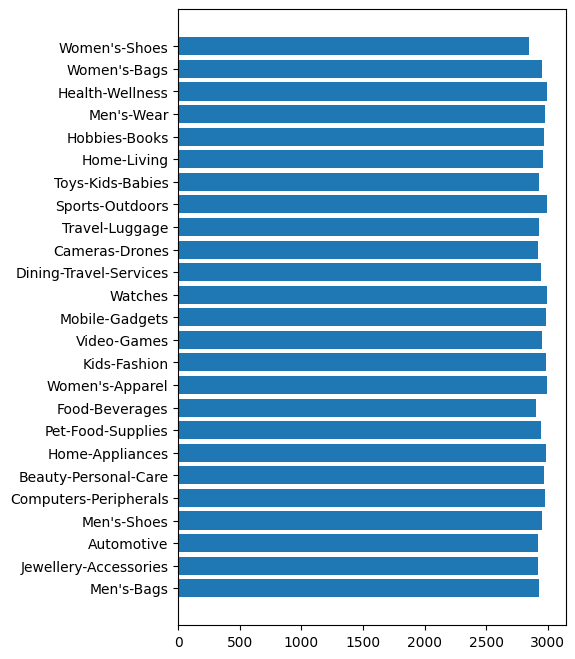

In [8]:
cats, items = zip(*data.image_count_per_category().items())
fig, ax = plt.subplots(figsize=(5, 8))
ax.barh(cats, items)

In [137]:
data.load_all()

100%|██████████| 100/100 [00:00<00:00, 266.82it/s]
0it [00:00, ?it/s]
100%|██████████| 100/100 [00:00<00:00, 223.34it/s]
0it [00:00, ?it/s]
100%|██████████| 100/100 [00:00<00:00, 209.32it/s]


In [10]:
all_categories = data.categories
widgets.interact_manual.opts['manual_name'] = 'Show samples'
im = widgets.interact_manual(lambda category: data.plot_samples(category), category=all_categories)

interactive(children=(Dropdown(description='category', options=('Automotive', 'Beauty-Personal-Care', 'Cameras…

In [18]:
#TODO: Check if need to normalize data or convert shapes
all_categories

['Automotive',
 'Beauty-Personal-Care',
 'Cameras-Drones',
 'Computers-Peripherals',
 'Dining-Travel-Services',
 'Food-Beverages',
 'Health-Wellness',
 'Hobbies-Books',
 'Home-Appliances',
 'Home-Living',
 'Jewellery-Accessories',
 'Kids-Fashion',
 "Men's-Bags",
 "Men's-Shoes",
 "Men's-Wear",
 'Miscellaneous',
 'Mobile-Gadgets',
 'Pet-Food-Supplies',
 'ShopeePay-Near-Me',
 'Sports-Outdoors',
 'Toys-Kids-Babies',
 'Travel-Luggage',
 'Video-Games',
 'Watches',
 "Women's-Apparel",
 "Women's-Bags",
 "Women's-Shoes"]

In [ ]:
cat_map = dict(zip(all_categories, range(0, len(all_categories))))
cat_map

# Prepare Train and Test Dataset

In [140]:
all_data=[]
for i in range(len(data.images)):
   all_data.append([data.images[i], data.labels[i]])

In [142]:
#Splitting on indices to get the set of images and labels
indices = np.arange(len(data.images))
train_data, test_data = train_test_split(all_data, test_size=0.2, random_state = 42)
print(len(train_data))
print(len(test_data))


2000
500


In [143]:
trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

# CNN Baseline Model

In [144]:
num_epoch = 20
batch_size = 32

In [145]:
model = models.resnet18(pretrained=True)
model.classifier = nn.Sequential()
#for param in model.parameters():
#    param.requires_grad = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [146]:
for epoch in range(num_epoch):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        y_pred = model.forward(inputs)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 100 == 0:
            print('epoch {:3d} | {:5d} batches loss: {:.4f}'.format(epoch, i + 1, running_loss/100))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [147]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [148]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        #images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 7 %
